## Kinematics Analysis

Analysis Notebook for Hands-On Clinical Biomechanics Kinematics project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ezc3d
from scipy import signal
from scipy import stats
import os
from pathlib import Path
from scipy.spatial.transform import Rotation as R
from collections import OrderedDict
import c3d

Load all folder paths in the following cell. Each "P0X" folder should contain all files of the data, so no theia subfolders.

In [ ]:
# rotations_p1d2 = rot_P01_Dynamic4.data.rotations;
# % rotlabels_p1d2 = rot_P01_Dynamic2.parameters.ROTATION.LABELS.DATA#
root = "/Users/rohangirish/" \
    "Library/CloudStorage/OneDrive-Personal/Desktop/UNI/DBE/Semester 3/HO Clinical Biomechanics/project/" \
    "Kinematics/"

In [ ]:
def load_subject_data(subject_folder):
    """
    Load all rotation data and events data for a subject
    """
    rotations_dict = {}
    events_dict = {}

    files = [f for f in os.listdir(subject_folder) if f.endswith('.c3d')]

    # Group files by condition
    conditions = {}
    for file in files:
        # Extract condition number from filename (e.g., "Dynamic 1.c3d" -> 1)
        if file.startswith("Dynamic "):
            if "_Theia" in file:
                # Theia file (contains rotations)
                condition = int(file.split("Dynamic ")[1].split("_Theia")[0])
                if condition not in conditions:
                    conditions[condition] = {"theia": None, "events": None}
                conditions[condition]["theia"] = os.path.join(subject_folder, file)
            else:
                # Regular file (contains events)
                condition = int(file.split("Dynamic ")[1].split(".c3d")[0])
                if condition not in conditions:
                    conditions[condition] = {"theia": None, "events": None}
                conditions[condition]["events"] = os.path.join(subject_folder, file)

    for condition, files in conditions.items():
        # Load rotations from Theia file
        if files["theia"] and os.path.exists(files["theia"]):
            try:
                c3d_theia = ezc3d.c3d(files["theia"])
                rot_data = c3d_theia['data']['rotations']
                n_rows, n_cols, n_segments, n_frames = rot_data.shape

                segment_labels = []
                for group in c3d_theia['parameters']:
                    if 'LABELS' in c3d_theia['parameters'][group]:
                        labels = c3d_theia['parameters'][group]['LABELS']['value']
                        if len(labels) == n_segments:
                            segment_labels = labels
                            break

                if not segment_labels:
                    segment_labels = [f"Segment_{i}" for i in range(n_segments)]

                # Dict for each condition
                condition_name = f"Dynamic_{condition}"
                rotations_dict[condition_name] = {}

                # Store rotation matrices for each segment
                for i in range(n_segments):
                    segment_name = segment_labels[i]
                    rotations_dict[condition_name][segment_name] = {}

                    for frame in range(n_frames):
                        # Extract just the 3x3 rotation part
                        # TODO: is the translation part needed?
                        rotations_dict[condition_name][segment_name][frame] = rot_data[:3, :3, i, frame]
            except Exception as e:
                print(f"Error loading Theia file: {e}")
        else:
            print(f"Theia file not found for condition {condition}")

        # Load events from regular file
        if files["events"] and os.path.exists(files["events"]):
            try:
                c3d_events = ezc3d.c3d(files["events"])

                if 'EVENT' in c3d_events['parameters']:
                    event_times = c3d_events['parameters']['EVENT']['TIMES']['value']
                    event_labels = c3d_events['parameters']['EVENT']['LABELS']['value']

                    # Convert times to frames directly
                    frame_to_event = {}
                    time_values = event_times[1]
                    frame_rate = 50

                    # Create frame-to-event mapping
                    for time, label in zip(time_values, event_labels):
                        frame = int(np.round(time * frame_rate))
                        frame_to_event[frame] = label

                    # Store the frame-to-event mapping
                    events_dict[condition_name] = frame_to_event
                else:
                    print("  No events found in file")
            except Exception as e:
                print(f"  Error loading events file: {e}")
        else:
            print(f"  Events file not found for condition {condition}")

    return rotations_dict, events_dict

## Analysis

1. Calculate lower limb (ankle, knee, hip) and arm kinematics (sequence XYZ) in all
three planes from the rotation matrices extracted from Theia for both sides (left and
right) for all trials and subjects.

- Cut all steps (both sides) from each trial using the heel-strike events and time normalize (101 data points) kinematics to the gait cycle.
- Plot kinematics of all steps for both sides for each subject

In [142]:
def calculate_kinematics(rot_data_dict, event_labels, event_times):
    """
    Calculate kinematics for all frames using dictionary format rotation data

    """
    # Segment mapping
    segment_mapping = {
        'pelvis': 'pelvis_4X4',
        'l_thigh': 'l_thigh_4X4',
        'l_shank': 'l_shank_4X4',
        'l_foot': 'l_foot_4X4',
        'r_thigh': 'r_thigh_4X4',
        'r_shank': 'r_shank_4X4',
        'r_foot': 'r_foot_4X4'
    }

    # Get number of frames from the first segment
    first_segment = next(iter(rot_data_dict.values()))
    num_frames = len(first_segment)
    frame_rate = 50

    time_vector = np.arange(num_frames) / frame_rate

    # Initialize kinematics
    kinematics = {
        'time': time_vector,
        'hip_left': np.zeros((num_frames, 3)),
        'knee_left': np.zeros((num_frames, 3)),
        'ankle_left': np.zeros((num_frames, 3)),
        'hip_right': np.zeros((num_frames, 3)),
        'knee_right': np.zeros((num_frames, 3)),
        'ankle_right': np.zeros((num_frames, 3))
    }

    # Initialize events
    events = {
        'time': [],
        'label': []
    }

    # Define valid labels to ignore Trigger Event label
    valid_labels = ["Left Foot Strike", "Right Foot Strike",
                   "heel strike left", "heel strike right"]

    # Access the correct row of event_times (second row as before)
    if isinstance(event_times, np.ndarray) and event_times.ndim > 1:
        time_values = event_times[1]
    else:
        time_values = event_times

    # Populate the times and events
    for i in range(len(time_values)):
        if i < len(event_labels) and event_labels[i] in valid_labels:
            events['time'].append(time_values[i])
            events['label'].append(event_labels[i])

    missing_segments = []
    for key, segment_name in segment_mapping.items():
        if segment_name not in rot_data_dict:
            missing_segments.append(segment_name)

    if missing_segments:
        print(f"Warning: Missing segments: {missing_segments}")
        print(f"Available segments: {list(rot_data_dict.keys())}")
        return kinematics, events

    # Process each frame to calculate kinematics
    for frame in range(num_frames):
        # Get only the 3x3 rotation matrix (no translation part)
        R_pelvis = rot_data_dict[segment_mapping['pelvis']][frame][:3, :3]

        # Left side
        R_l_thigh = rot_data_dict[segment_mapping['l_thigh']][frame][:3, :3]
        R_l_shank = rot_data_dict[segment_mapping['l_shank']][frame][:3, :3]
        R_l_foot = rot_data_dict[segment_mapping['l_foot']][frame][:3, :3]

        # Right side
        R_r_thigh = rot_data_dict[segment_mapping['r_thigh']][frame][:3, :3]
        R_r_shank = rot_data_dict[segment_mapping['r_shank']][frame][:3, :3]
        R_r_foot = rot_data_dict[segment_mapping['r_foot']][frame][:3, :3]

        # Relative matrix is R.T * R
        R_hip_left = R_pelvis.T @ R_l_thigh
        R_knee_left = R_l_thigh.T @ R_l_shank
        R_ankle_left = R_l_shank.T @ R_l_foot

        R_hip_right = R_pelvis.T @ R_r_thigh
        R_knee_right = R_r_thigh.T @ R_r_shank
        R_ankle_right = R_r_shank.T @ R_r_foot

        # Euler angles, xyz sequence, converted to degrees
        hip_left_angles = R.from_matrix(R_hip_left).as_euler('xyz', degrees=True)
        knee_left_angles = R.from_matrix(R_knee_left).as_euler('xyz', degrees=True)
        ankle_left_angles = R.from_matrix(R_ankle_left).as_euler('xyz', degrees=True)
        hip_right_angles = R.from_matrix(R_hip_right).as_euler('xyz', degrees=True)
        knee_right_angles = R.from_matrix(R_knee_right).as_euler('xyz', degrees=True)
        ankle_right_angles = R.from_matrix(R_ankle_right).as_euler('xyz', degrees=True)

        # Store angles with knee flexion/extension flipped
        kinematics['hip_left'][frame, :] = hip_left_angles
        kinematics['knee_left'][frame, :] = knee_left_angles
        kinematics['ankle_left'][frame, :] = ankle_left_angles
        kinematics['hip_right'][frame, :] = hip_right_angles
        kinematics['knee_right'][frame, :] = knee_right_angles
        kinematics['ankle_right'][frame, :] = ankle_right_angles

        # Flip knee flexion/extension (axis 0) to make flexion positive, convention
        kinematics['knee_left'][frame, 0] = -knee_left_angles[0]
        kinematics['knee_right'][frame, 0] = -knee_right_angles[0]

    return kinematics, events

def process_gait_cycles(data, axis_index, events):
    """
    Process gait cycles.
    """
    axis_data = data[:, axis_index]
    time_in_seconds = np.arange(len(data)) / 50

    # Split the trial into 2 halves
    trial_half_time = time_in_seconds[-1] / 2

    # Convert events to numpy arrays for easier filtering
    event_times = np.array(events['time'])
    event_labels = np.array(events['label'])

    # Filter events by half and type
    left_mask_first = ((event_labels == "Left Foot Strike") |
                      (event_labels == "heel strike left")) & (event_times <= trial_half_time)
    right_mask_first = ((event_labels == "Right Foot Strike") |
                       (event_labels == "heel strike right")) & (event_times <= trial_half_time)

    left_mask_second = ((event_labels == "Left Foot Strike") |
                       (event_labels == "heel strike left")) & (event_times > trial_half_time)
    right_mask_second = ((event_labels == "Right Foot Strike") |
                        (event_labels == "heel strike right")) & (event_times > trial_half_time)

    left_strikes_first_half = event_times[left_mask_first]
    right_strikes_first_half = event_times[right_mask_first]
    left_strikes_second_half = event_times[left_mask_second]
    right_strikes_second_half = event_times[right_mask_second]

    # Initialize normalized cycles
    normalized_cycles = {'left': [], 'right': []}

    # Function to extract and normalize cycles
    def extract_cycles(strike_times, side_key):
        for i in range(len(strike_times) - 1):
            start_time = strike_times[i]
            end_time = strike_times[i + 1]

            # Find indices
            start_idx = np.where(time_in_seconds >= start_time)[0]
            end_idx = np.where(time_in_seconds <= end_time)[0]

            if len(start_idx) > 0 and len(end_idx) > 0:
                start_idx = start_idx[0]
                end_idx = end_idx[-1]

                # Extract cycle data
                cycle_data = axis_data[start_idx:end_idx+1]

                # Interpolate to 101 points (linspace_data equivalent)
                if len(cycle_data) > 1:
                    x_original = np.linspace(0, 1, len(cycle_data))
                    x_new = np.linspace(0, 1, 101)
                    resampled_data = np.interp(x_new, x_original, cycle_data)
                    normalized_cycles[side_key].append(resampled_data)

    # Extract cycles for all halves
    extract_cycles(left_strikes_first_half, 'left')
    extract_cycles(right_strikes_first_half, 'right')
    extract_cycles(left_strikes_second_half, 'left')
    extract_cycles(right_strikes_second_half, 'right')

    # Convert lists to numpy arrays
    if normalized_cycles['left']:
        normalized_cycles['left'] = np.array(normalized_cycles['left'])
    else:
        normalized_cycles['left'] = np.array([]).reshape(0, 101)

    if normalized_cycles['right']:
        normalized_cycles['right'] = np.array(normalized_cycles['right'])
    else:
        normalized_cycles['right'] = np.array([]).reshape(0, 101)

    return normalized_cycles


def plot_gait_cycles(normalized_cycles, segment_side, axis_index, subject_num, dynamic_num, save_plots=False):
    """
    Plot gait cycles following the MATLAB style
    """
    # Axis labels
    axis_labels = ['Flex/Extension', 'Ab/Adduction', 'Int/External Rotation']
    axis_label = axis_labels[axis_index]

    # Split segment_side
    parts = segment_side.split('_')
    segment_name = parts[0].capitalize()
    side = parts[1].capitalize()

    # Determine which side to plot based on segment_side
    if 'left' in segment_side.lower():
        cycles_to_plot = normalized_cycles['left'] if len(normalized_cycles['left']) > 0 else None
        plot_side = 'Left'
    else:
        cycles_to_plot = normalized_cycles['right'] if len(normalized_cycles['right']) > 0 else None
        plot_side = 'Right'

    if cycles_to_plot is None or len(cycles_to_plot) == 0:
        print(f"No cycles found for {segment_side}")
        return

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot title
    title_info = f"P{subject_num:02d} Condition {dynamic_num}"
    full_title = f"{title_info}\n{segment_name} {side} Gait Cycle {axis_label} ({plot_side} Foot)"
    plt.title(full_title)

    # Plot each cycle
    x = np.linspace(0, 100, 101)
    for i in range(len(cycles_to_plot)):
        plt.plot(x, cycles_to_plot[i], linewidth=2)

    plt.xlabel('Gait Cycle Percentage (%)')
    plt.ylabel('Angle (Degrees)')
    plt.grid(True)
    plt.tight_layout()

    if save_plots:
        filename = f'P{subject_num:02d}_Condition{dynamic_num}_{segment_side}_{plot_side}.png'
        plt.savefig(filename)

    plt.show()


def process_and_plot_gait(rot_data_dict, events_dict, segment_side, axis_index, subject_num, dynamic_num, save_plots=False):
    """
    Complete function to process and plot gait cycles directly.
    """
    # Convert events_dict back to the format
    event_times_list = []
    event_labels_list = []

    # Convert frame-based events back to time-based
    for frame, label in sorted(events_dict.items()):
        event_times_list.append(frame / 50)
        event_labels_list.append(label)

    # Create event_times array in the format expected (2D array)
    event_times = np.array([np.zeros(len(event_times_list)), event_times_list])

    # Calculate kinematics using MATLAB approach
    kinematics, events = calculate_kinematics(rot_data_dict, event_labels_list, event_times)

    # Get segment data
    if segment_side not in kinematics:
        print(f"Segment '{segment_side}' not found in kinematics data")
        print(f"Available segments: {list(kinematics.keys())}")
        return None

    segment_data = kinematics[segment_side]

    # Process gait cycles
    normalized_gait_cycles = process_gait_cycles(segment_data, axis_index, events)

    # Plot
    plot_gait_cycles(normalized_gait_cycles, segment_side, axis_index,
                                 subject_num, dynamic_num, save_plots)

    return normalized_gait_cycles


Dynamic 0 not found for subject P01


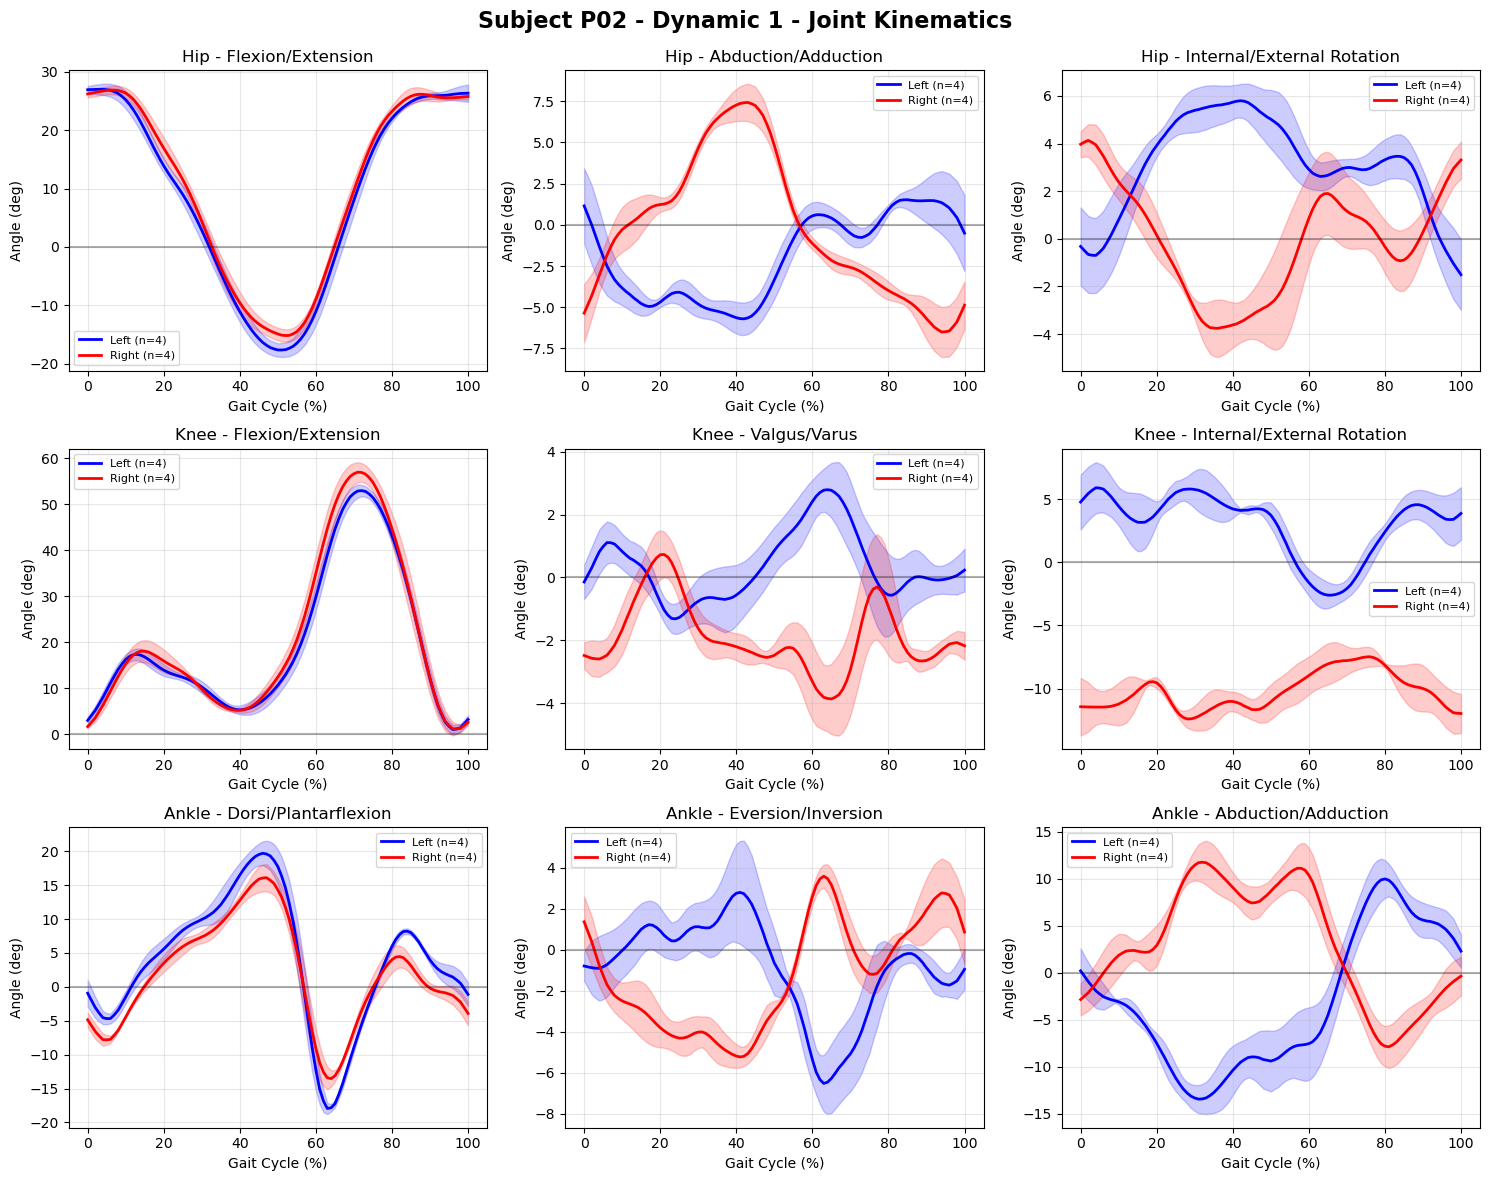

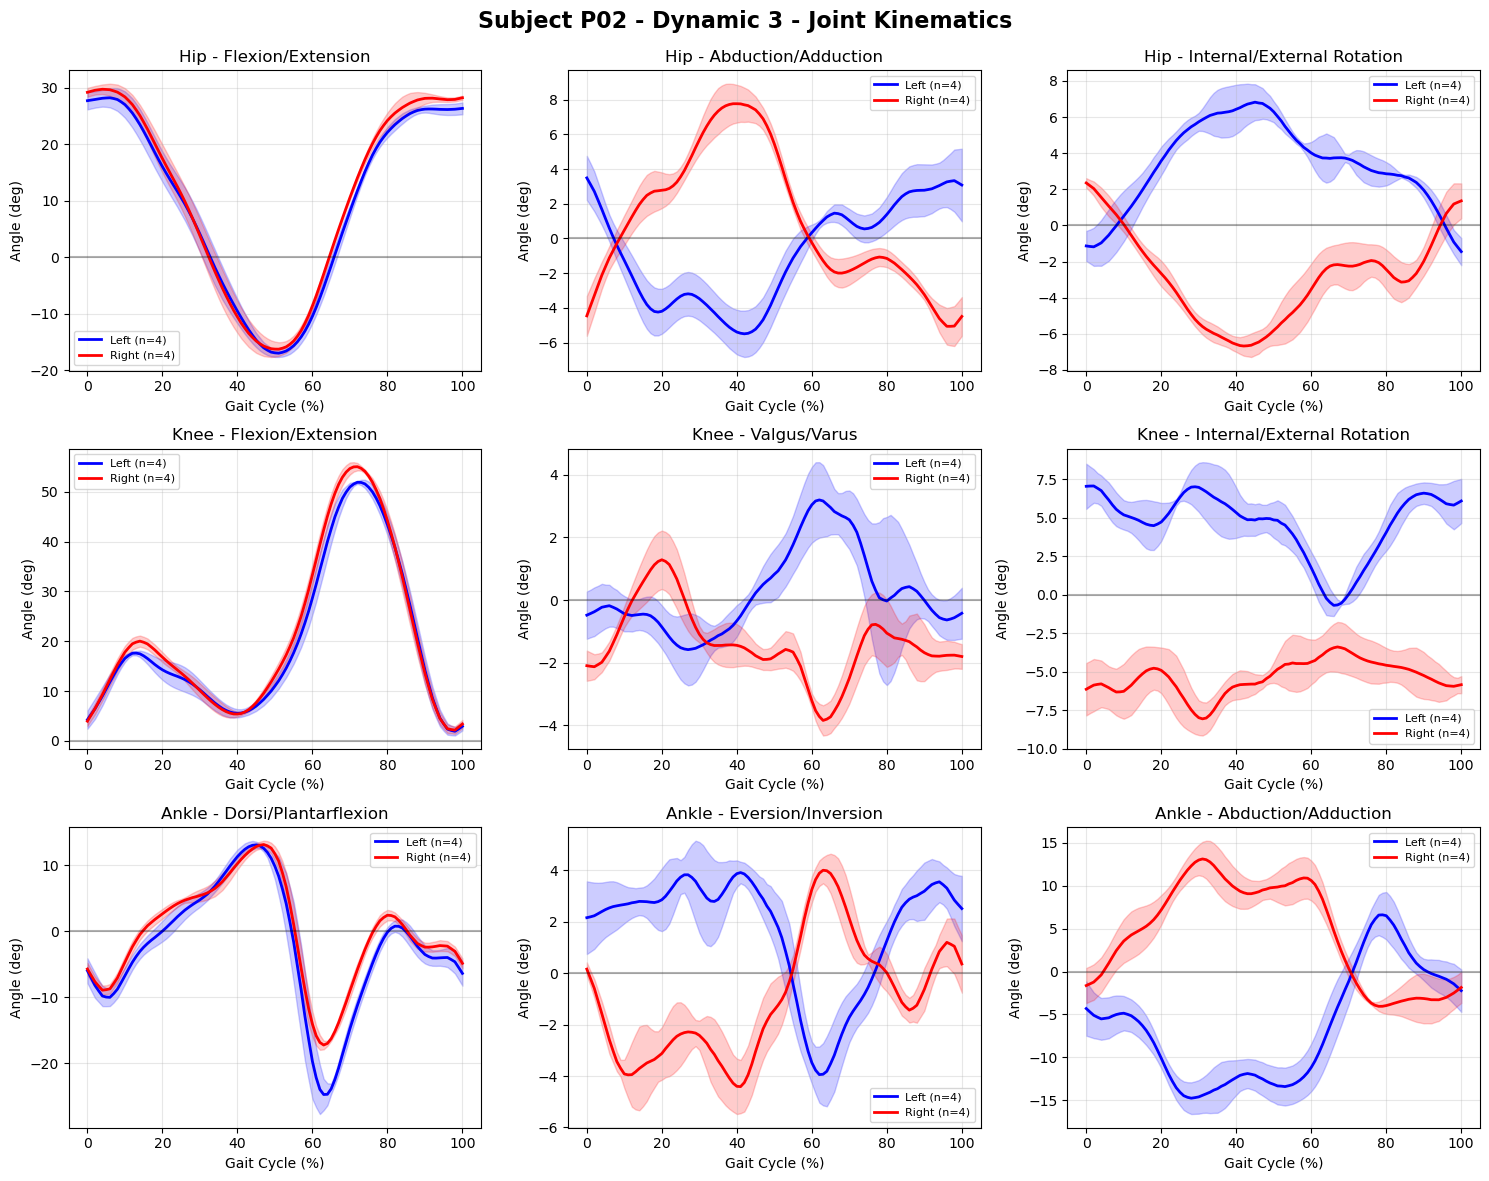

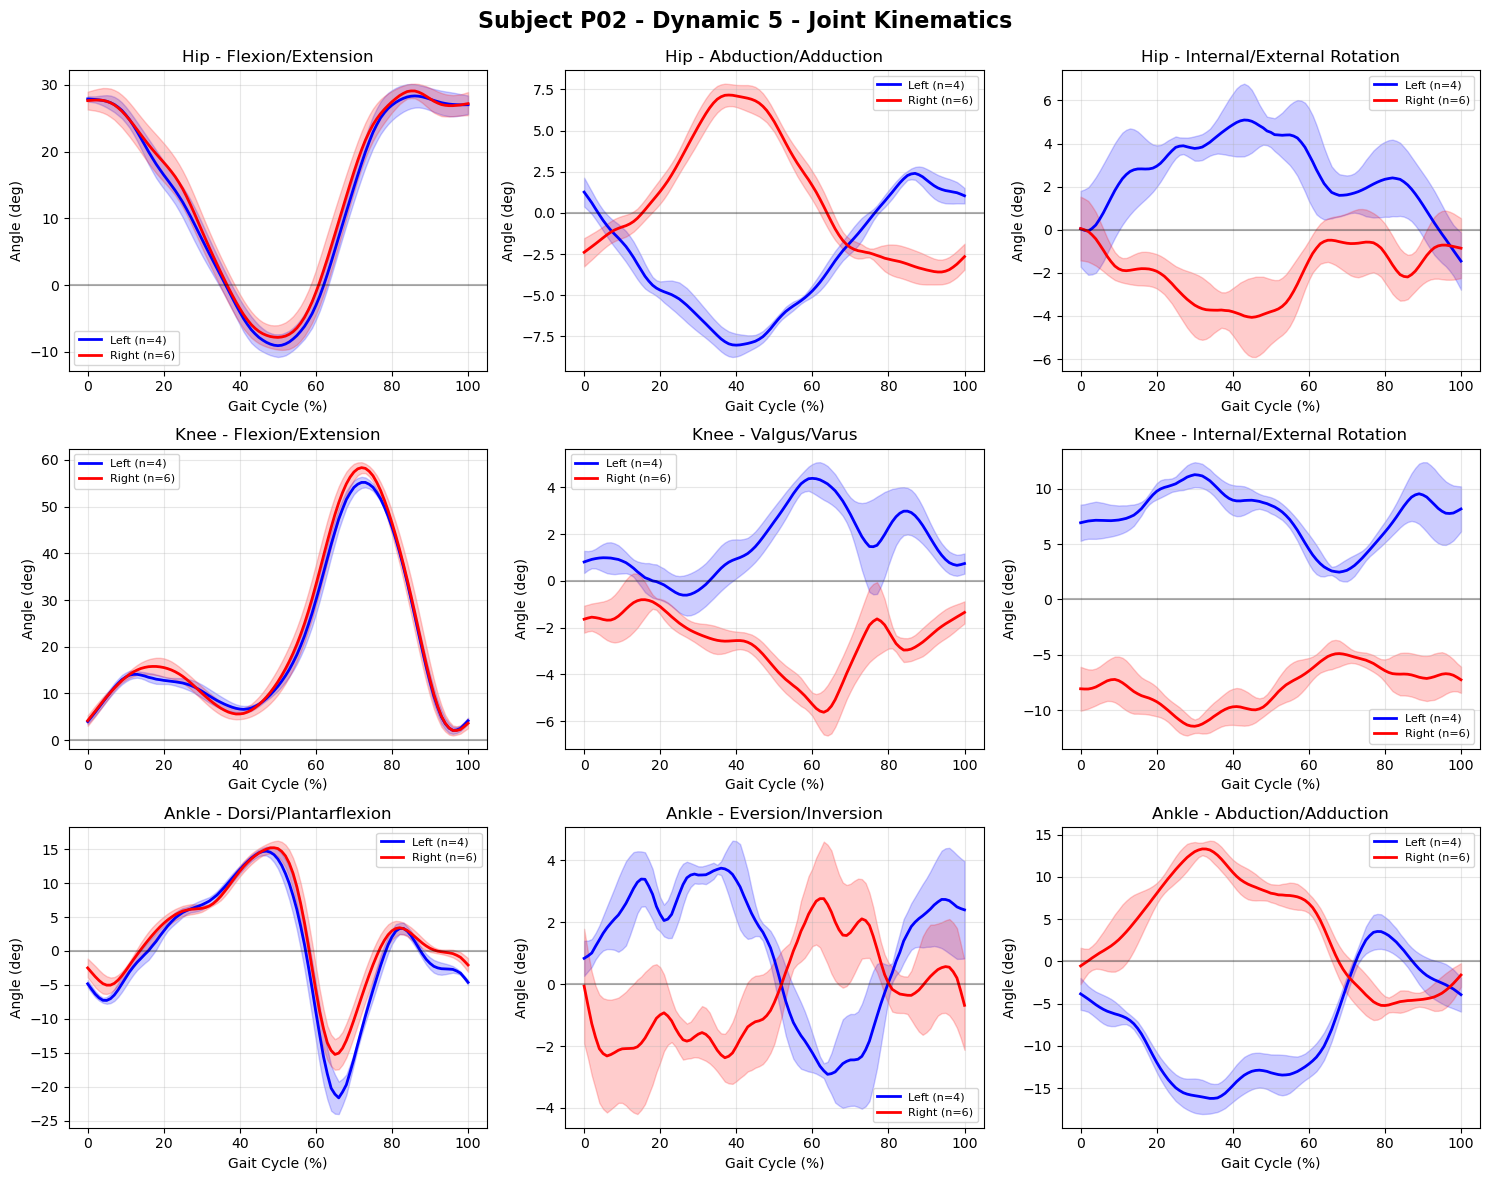

In [149]:
def process_and_plot_gait_complete(folder="Kinematics", joint_name=None, subject_name=1, dynamic_num=1, axis_index=0, save_plots=False):
    """
    Complete process following MATLAB approach - loads data automatically

    """
    # Load data
    subject_folder = f"Kinematics/P{subject_name:02d}"
    rot_data, events_data = load_subject_data(subject_folder)

    # Get specific dynamic trial
    dynamic_key = f'Dynamic_{dynamic_num}'

    if dynamic_key not in rot_data or dynamic_key not in events_data:
        print(f"Dynamic {dynamic_num} not found for subject P{subject_name:02d}")
        return None

    rot_trial = rot_data[dynamic_key]
    events_trial = events_data[dynamic_key]

    # Convert events_dict back to the format needed
    event_times_list = []
    event_labels_list = []

    # Convert frame-based events back to time-based
    for frame, label in sorted(events_trial.items()):
        event_times_list.append(frame / 50)
        event_labels_list.append(label)

    event_times = np.array([np.zeros(len(event_times_list)), event_times_list])

    # Calculate kinematics
    kinematics, events = calculate_kinematics(rot_trial, event_labels_list, event_times)

    # Get segment data
    if joint_name not in kinematics:
        print(f"Joint '{joint_name}' not found in kinematics data")
        print(f"Available joints: {list(kinematics.keys())}")
        return None

    segment_data = kinematics[joint_name]

    # Process gait cycles
    normalized_gait_cycles = process_gait_cycles(segment_data, axis_index, events)

    # Calculate mean cycles and count cycles
    mean_cycles = {}
    cycle_counts = {}

    for side in ['left', 'right']:
        if len(normalized_gait_cycles[side]) > 0:
            mean_cycles[side] = np.mean(normalized_gait_cycles[side], axis=0)
            cycle_counts[side] = len(normalized_gait_cycles[side])
        else:
            mean_cycles[side] = np.array([])
            cycle_counts[side] = 0

    # Plot individual cycles
    plot_gait_cycles(normalized_gait_cycles, joint_name, axis_index,
                                 subject_name, dynamic_num, save_plots)

    # Plot mean cycles
    # plot_mean_cycles(mean_cycles, cycle_counts, joint_name, axis_index,
    #                  subject_name, dynamic_num, save_plots)

    results = {
        'normalized_cycles': normalized_gait_cycles,
        'mean_cycles': mean_cycles,
        'cycle_counts': cycle_counts,
        'kinematics': kinematics,
        'events': events
    }

    return results

def plot_mean_cycles(mean_cycles, cycle_counts, joint_name, axis_index, subject_num, dynamic_num, save_plots=False):
    """
    Plot mean gait cycles for both sides
    """
    # Axis labels
    axis_labels = ['Flex/Extension', 'Ab/Adduction', 'Int/External Rotation']
    axis_label = axis_labels[axis_index]

    # Split joint_name
    parts = joint_name.split('_')
    joint_type = parts[0].capitalize()

    # Create plot
    plt.figure(figsize=(12, 6))

    # Plot title
    title_info = f"P{subject_num:02d} Condition {dynamic_num}"
    full_title = f"{title_info}\n{joint_type} Mean Gait Cycle {axis_label}"
    plt.title(full_title)

    # Gait cycle percentage
    x = np.linspace(0, 100, 101)

    # Plot left side
    if len(mean_cycles['left']) > 0:
        plt.plot(x, mean_cycles['left'], 'b-', linewidth=3,
                label=f'Left (n={cycle_counts["left"]})')

    # Plot right side
    if len(mean_cycles['right']) > 0:
        plt.plot(x, mean_cycles['right'], 'r-', linewidth=3,
                label=f'Right (n={cycle_counts["right"]})')

    plt.axvline(x=60, color='gray', linestyle='--', alpha=0.7, label='Toe-off')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.xlabel('Gait Cycle Percentage (%)')
    plt.ylabel('Angle (Degrees)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_plots:
        filename = f'P{subject_num:02d}_Condition{dynamic_num}_{joint_name}_Mean.png'
        plt.savefig(filename)

    plt.show()


def plot_subject_kinematics_grid_auto(subject_name, dynamic_num, save_plots=False):
    """
    Plot a 3x3 grid of mean kinematic trajectories for all joints and axes

    """
    # Define joints and their anatomical movements
    joints_info = {
        'hip': {
            'joint_names': ['hip_left', 'hip_right'],
            'movements': ['Flexion/Extension', 'Abduction/Adduction', 'Internal/External Rotation']
        },
        'knee': {
            'joint_names': ['knee_left', 'knee_right'],
            'movements': ['Flexion/Extension', 'Valgus/Varus', 'Internal/External Rotation']
        },
        'ankle': {
            'joint_names': ['ankle_left', 'ankle_right'],
            'movements': ['Dorsi/Plantarflexion', 'Eversion/Inversion', 'Abduction/Adduction']
        }
    }

    # Load data once for efficiency
    subject_folder = f"Kinematics/P{subject_name:02d}"
    rot_data, events_data = load_subject_data(subject_folder)

    dynamic_key = f'Dynamic_{dynamic_num}'
    if dynamic_key not in rot_data or dynamic_key not in events_data:
        print(f"Dynamic {dynamic_num} not found for subject P{subject_name:02d}")
        return None

    rot_trial = rot_data[dynamic_key]
    events_trial = events_data[dynamic_key]

    # Convert events
    event_times_list = []
    event_labels_list = []
    for frame, label in sorted(events_trial.items()):
        event_times_list.append(frame / 50)
        event_labels_list.append(label)

    event_times = np.array([np.zeros(len(event_times_list)), event_times_list])

    # Calculate kinematics once
    kinematics, events = calculate_kinematics(rot_trial, event_labels_list, event_times)

    # Create the 3x3 subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    all_results = {}
    joint_list = ['hip', 'knee', 'ankle']

    for row, joint_type in enumerate(joint_list):
        for col in range(3):
            ax = axes[row, col]

            # Get joint info
            joint_names = joints_info[joint_type]['joint_names']
            movement_name = joints_info[joint_type]['movements'][col]

            # Store results for this joint and axis
            joint_axis_key = f"{joint_type}_axis{col}"
            all_results[joint_axis_key] = {'left': {}, 'right': {}}

            # Process both left and right sides for this joint and axis
            for side_idx, joint_name in enumerate(joint_names):
                if joint_name not in kinematics:
                    continue

                # Get normalized cycles for this joint and axis
                segment_data = kinematics[joint_name]
                normalized_cycles = process_gait_cycles(segment_data, col, events)

                side = 'left' if 'left' in joint_name else 'right'
                color = 'blue' if side == 'left' else 'red'

                # Calculate mean and store results
                if side in normalized_cycles and len(normalized_cycles[side]) > 0:
                    cycles_array = normalized_cycles[side]
                    mean_trajectory = np.mean(cycles_array, axis=0)
                    std_trajectory = np.std(cycles_array, axis=0)
                    cycle_count = len(cycles_array)

                    # Store results
                    all_results[joint_axis_key][side] = {
                        'normalized_cycles': cycles_array,
                        'mean_trajectory': mean_trajectory,
                        'std_trajectory': std_trajectory,
                        'cycle_count': cycle_count
                    }

                    gait_cycle = np.linspace(0, 100, 101)

                    ax.plot(gait_cycle, mean_trajectory, color=color, linewidth=2,
                           label=f'{side.capitalize()} (n={cycle_count})')

                    # Plot standard deviation as shaded area
                    ax.fill_between(gait_cycle,
                                   mean_trajectory - std_trajectory,
                                   mean_trajectory + std_trajectory,
                                   color=color, alpha=0.2)
                else:
                    all_results[joint_axis_key][side] = {
                        'normalized_cycles': np.array([]),
                        'mean_trajectory': np.array([]),
                        'std_trajectory': np.array([]),
                        'cycle_count': 0
                    }

            # Add reference lines
            # ax.axvline(x=60, color='gray', linestyle='--', alpha=0.7)  # Toe-off
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)   # Zero line

            # Set labels and formatting
            ax.set_xlabel('Gait Cycle (%)')
            ax.set_ylabel('Angle (deg)')
            ax.set_title(f'{joint_type.capitalize()} - {movement_name}')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

    plt.suptitle(f'Subject P{subject_name:02d} - Dynamic {dynamic_num} - Joint Kinematics',
                 fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    if save_plots:
        filename = f'P{subject_name:02d}_Dynamic{dynamic_num}_Grid.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

    # Print summary
    # print(f"\nSummary for Subject P{subject_name:02d} - Dynamic {dynamic_num}:")
    # for joint_type in joint_list:
    #     for col in range(3):
    #         movement_name = joints_info[joint_type]['movements'][col]
    #         joint_axis_key = f"{joint_type}_axis{col}"
    #         left_count = all_results[joint_axis_key]['left']['cycle_count']
    #         right_count = all_results[joint_axis_key]['right']['cycle_count']
    #         print(f"  {joint_type.capitalize()} {movement_name}: Left={left_count}, Right={right_count} cycles")

    return all_results


results = process_and_plot_gait_complete('knee_left', 1, 1, 0, save_plots=False)

# For 3x3 grid analysis:
all_results = plot_subject_kinematics_grid_auto(2, 1, save_plots=False)
all_results = plot_subject_kinematics_grid_auto(2, 3, save_plots=False)
all_results = plot_subject_kinematics_grid_auto(2, 5, save_plots=False)

# knee_flexion_results = all_results['knee_axis0']
# left_knee_mean = knee_flexion_results['left']['mean_trajectory']
# left_knee_cycles = knee_flexion_results['left']['normalized_cycles']

In [148]:
def plot_subject_kinematics_6x3_grid(subject_name, dynamic_num, save_plots=False):
    """
    Plot a 6x3 grid of mean kinematic trajectories for all joints and sides

    """
    # Define joints and their anatomical movements
    joints_info = {
        'hip_left': {
            'movements': ['Flex/Extension', 'Ab/Adduction', 'Internal/External Rotation'],
            'title': 'Hip Left'
        },
        'knee_left': {
            'movements': ['Flex/Extension', 'Ab/Adduction', 'Internal/External Rotation'],
            'title': 'Knee Left'
        },
        'ankle_left': {
            'movements': ['Dorsi/Plantarflexion', 'Inv/Eversion', 'Toe In/Out'],
            'title': 'Ankle Left'
        },
        'hip_right': {
            'movements': ['Flex/Extension', 'Ab/Adduction', 'Int/External Rotation'],
            'title': 'Hip Right'
        },
        'knee_right': {
            'movements': ['Flex/Extension', 'Ab/Adduction', 'Int/External Rotation'],
            'title': 'Knee Right'
        },
        'ankle_right': {
            'movements': ['Dorsi/Plantarflexion', 'Inv/Eversion', 'Toe In/Out'],
            'title': 'Ankle Right'
        }
    }

    # Load data once for efficiency
    subject_folder = f"Kinematics/P{subject_name:02d}"
    rot_data, events_data = load_subject_data(subject_folder)

    dynamic_key = f'Dynamic_{dynamic_num}'
    if dynamic_key not in rot_data or dynamic_key not in events_data:
        print(f"Dynamic {dynamic_num} not found for subject P{subject_name:02d}")
        return None

    rot_trial = rot_data[dynamic_key]
    events_trial = events_data[dynamic_key]

    # Convert events
    event_times_list = []
    event_labels_list = []
    for frame, label in sorted(events_trial.items()):
        event_times_list.append(frame / 50)
        event_labels_list.append(label)

    event_times = np.array([np.zeros(len(event_times_list)), event_times_list])

    # Calculate kinematics once
    kinematics, events = calculate_kinematics(rot_trial, event_labels_list, event_times)

    # Create the 6x3 subplot grid
    fig, axes = plt.subplots(6, 3, figsize=(15, 18))

    # Store all results
    all_results = {}

    # Process each joint (rows) and axis (columns)
    joint_list = ['hip_left', 'knee_left', 'ankle_left', 'hip_right', 'knee_right', 'ankle_right']

    for row, joint_name in enumerate(joint_list):
        for col in range(3):  # 3 axes
            ax = axes[row, col]

            # Get joint info
            movement_name = joints_info[joint_name]['movements'][col]
            joint_title = joints_info[joint_name]['title']

            # Store results for this joint and axis
            joint_axis_key = f"{joint_name}_axis{col}"
            all_results[joint_axis_key] = {'left_strikes': {}, 'right_strikes': {}}

            if joint_name not in kinematics:
                ax.text(0.5, 0.5, f'{joint_name}\nNot Available',
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'{joint_title} - {movement_name}')
                continue

            # Get normalized cycles for this joint and axis
            segment_data = kinematics[joint_name]
            normalized_cycles = process_gait_cycles(segment_data, col, events)

            # Process left foot strike cycles
            if 'left' in normalized_cycles and len(normalized_cycles['left']) > 0:
                cycles_array = normalized_cycles['left']
                mean_trajectory = np.mean(cycles_array, axis=0)
                std_trajectory = np.std(cycles_array, axis=0)
                cycle_count = len(cycles_array)

                # Store results
                all_results[joint_axis_key]['left_strikes'] = {
                    'normalized_cycles': cycles_array,
                    'mean_trajectory': mean_trajectory,
                    'std_trajectory': std_trajectory,
                    'cycle_count': cycle_count
                }

                gait_cycle = np.linspace(0, 100, 101)

                # Plot mean line for left foot strikes
                ax.plot(gait_cycle, mean_trajectory, color='blue', linewidth=2,
                       label=f'Left strikes (n={cycle_count})')

                # Plot standard deviation
                ax.fill_between(gait_cycle,
                               mean_trajectory - std_trajectory,
                               mean_trajectory + std_trajectory,
                               color='blue', alpha=0.2)
            else:
                all_results[joint_axis_key]['left_strikes'] = {
                    'normalized_cycles': np.array([]),
                    'mean_trajectory': np.array([]),
                    'std_trajectory': np.array([]),
                    'cycle_count': 0
                }

            # Process right foot strike cycles
            if 'right' in normalized_cycles and len(normalized_cycles['right']) > 0:
                cycles_array = normalized_cycles['right']
                mean_trajectory = np.mean(cycles_array, axis=0)
                std_trajectory = np.std(cycles_array, axis=0)
                cycle_count = len(cycles_array)

                # Store results
                all_results[joint_axis_key]['right_strikes'] = {
                    'normalized_cycles': cycles_array,
                    'mean_trajectory': mean_trajectory,
                    'std_trajectory': std_trajectory,
                    'cycle_count': cycle_count
                }

                gait_cycle = np.linspace(0, 100, 101)

                # Plot mean line for right foot strikes
                ax.plot(gait_cycle, mean_trajectory, color='red', linewidth=2,
                       label=f'Right strikes (n={cycle_count})')

                # Plot standard deviation
                ax.fill_between(gait_cycle,
                               mean_trajectory - std_trajectory,
                               mean_trajectory + std_trajectory,
                               color='red', alpha=0.2)
            else:
                all_results[joint_axis_key]['right_strikes'] = {
                    'normalized_cycles': np.array([]),
                    'mean_trajectory': np.array([]),
                    'std_trajectory': np.array([]),
                    'cycle_count': 0
                }

            # Add reference lines
            ax.axvline(x=60, color='gray', linestyle='--', alpha=0.7)  # Toe-off
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)   # Zero line

            # Set labels and formatting
            ax.set_xlabel('Gait Cycle (%)', fontsize=10)
            ax.set_ylabel('Angle (deg)', fontsize=10)
            ax.set_title(f'{joint_title} - {movement_name}', fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

            # Adjust tick label size
            ax.tick_params(axis='both', which='major', labelsize=9)

    # Add overall title
    plt.suptitle(f'Subject P{subject_name:02d} - Dynamic {dynamic_num} - Complete Joint Kinematics',
                 fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    if save_plots:
        filename = f'P{subject_name:02d}_Dynamic{dynamic_num}_6x3_Grid.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

    # Print detailed summary
    # print(f"\nDetailed Summary for Subject P{subject_name:02d} - Dynamic {dynamic_num}:")
    # print("="*60)

    # for joint_name in joint_list:
    #     joint_title = joints_info[joint_name]['title']
    #     print(f"\n{joint_title}:")

    #     for col in range(3):
    #         movement_name = joints_info[joint_name]['movements'][col]
    #         joint_axis_key = f"{joint_name}_axis{col}"

    #         left_count = all_results[joint_axis_key]['left_strikes']['cycle_count']
    #         right_count = all_results[joint_axis_key]['right_strikes']['cycle_count']

    #         print(f"  {movement_name}: Left strikes={left_count}, Right strikes={right_count}")

    return all_results

# Helper function to analyze specific joint and axis from the results
def get_joint_axis_summary(all_results, joint_name, axis_index):
    joint_axis_key = f"{joint_name}_axis{axis_index}"

    if joint_axis_key not in all_results:
        print(f"Joint-axis combination '{joint_axis_key}' not found")
        return None

    data = all_results[joint_axis_key]

    summary = {
        'joint': joint_name,
        'axis': axis_index,
        'left_strikes': {
            'count': data['left_strikes']['cycle_count'],
            'mean_range': (np.min(data['left_strikes']['mean_trajectory']) if len(data['left_strikes']['mean_trajectory']) > 0 else None,
                          np.max(data['left_strikes']['mean_trajectory']) if len(data['left_strikes']['mean_trajectory']) > 0 else None),
            'rom': (np.max(data['left_strikes']['mean_trajectory']) - np.min(data['left_strikes']['mean_trajectory'])) if len(data['left_strikes']['mean_trajectory']) > 0 else None
        },
        'right_strikes': {
            'count': data['right_strikes']['cycle_count'],
            'mean_range': (np.min(data['right_strikes']['mean_trajectory']) if len(data['right_strikes']['mean_trajectory']) > 0 else None,
                          np.max(data['right_strikes']['mean_trajectory']) if len(data['right_strikes']['mean_trajectory']) > 0 else None),
            'rom': (np.max(data['right_strikes']['mean_trajectory']) - np.min(data['right_strikes']['mean_trajectory'])) if len(data['right_strikes']['mean_trajectory']) > 0 else None
        }
    }

    return summary

# all_results_6x3 = plot_subject_kinematics_6x3_grid(2, 1, save_plots=False)
# print(all_results_6x3)